# Optimization of Reinforced Concrete Production and Shipment: A Conveyor-Based Manufacturing and Curing Model

[![Advertising_campaign_colab.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Concrete_plant/Conveyor_curing.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Concrete_plant/Conveyor_curing.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Concrete_plant/Conveyor_curing.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Concrete_plant/Conveyor_curing.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/mikhail/Concrete_plant/Conveyor_curing.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/mikhail/Concrete_plant/Conveyor_curing.ipynb)](https://colab.ampl.com)

## Introduction

This optimization model addresses the daily production planning of a precast concrete plant, focused on efficiently fulfilling a complex order of varied concrete products. The plant operates on a conveyor line equipped with 48 moulding pallets, each with fixed dimensions, and relies on controlled curing processes to achieve the necessary concrete strength. A primary challenge is determining the optimal mix of products on each pallet to maximize space utilization, meet strength requirements, and minimize production costs, all while adhering to time-sensitive demand.

Concrete curing time is temperature-dependent, and the plant utilizes a steam chamber to accelerate this process. However, the chamber has constraints on temperature increase rates and cooling requirements, adding complexity to planning. Additionally, the model must manage labor resources effectively to minimize overtime costs, balancing the need for production efficiency against labor expenses.

This model’s objectives are to minimize total production costs, including labor and energy costs associated with curing, while meeting demand and maximizing pallet utilization. By capturing the intricate interactions between curing processes, product placement, and cost factors, this model provides a comprehensive solution for daily production planning, allowing the plant to meet order requirements with optimized resource use and minimal delays.

[*Partner with the AMPL team to transform complex problems into optimized solutions. AMPL consulting services combine deep technical knowledge with industry-leading insights, helping you unlock the full potential of optimization within your organization.*](https://ampl.com/services/)

Tags: Conveyor-Based Manufacturing, Concrete Production, MIP, ampl, Ilmore-Gomory, cbc

Notebook author: Mikhail Riabtsev <<mail@solverytic.com>>
***

## Problem statement

![alt text](concrete_.main.jpg)

A precast concrete plant has received an [order](concrete_demand.csv) to produce a variety of concrete products, requiring a well-optimized daily production plan to balance efficiency, demand, and costs. 
The plant operates a conveyor line equipped with 48 moulding pallets, each measuring 12,000 x 3,800 mm. The challenge is to determine the optimal number and types of products to place on each pallet, ensuring maximum utilization of available space while minimizing production costs.

### Concrete Curing Process

A critical aspect of production is the concrete curing time, which depends on temperature. The strength development of the concrete is modeled as follows:
![alt text](concrete_alpha.jpg)
> Relative Strength at Initial Temperature $𝑇_1$ ​: 
> 
> $ S_r(t_1) = 1 - exp(-α_1 * (t_1 - t_d)) $
> 
> Where:
> * $S_r(t_1) $ : Fraction of the ultimate strength gained after time $t_1$ at temperature $T_1$.
> * [$α_1$ : Rate constant ](concrete_alpha.csv) at $T_1$.
> * $t_d$ : Delay time before strength development starts (0 by default).
>
> When the temperature changes to $𝑇_2$, calculate the equivalent time $𝑡_e$ at $𝑇_2$ that corresponds to the relative strength already gained at $𝑡_1$ :
>
> $S_r(t_1) = 1 - exp(-α_2 * t_e)$
>
> Solving for  $t_e$ :
>
> $t_e = -(1 / α_2) * ln(1 - S_r(t_1))$
>
> Where:
> * $α_2$ - is the rate constant at the new temperature $T_2$.
> * $t_e$ - is the equivalent time at temperature $T_2$.
>
>After the temperature changes, the relative strength continues to grow based on the new temperature $𝑇_2$. After spending an additional time $𝑡_2$ at $𝑇_2$, the total relative strength is:
>
>$S_rtotal = 1 - exp(-α_2 * (t_e + t_2))$
>
>Where:
>* $t_2$ - is the additional time spent at temperature $𝑇_2$.
>* $S_rtotal$ - is the total relative strength after both phases (initial time 
$𝑡_1$ at $T_1$ and additional time $𝑡_2$ at $T_2$).
>

### Steam Chamber Process

To accelerate the curing of concrete, the plant uses a steam chamber with a capacity of 25 pallets. The heating costs depend on the target temperature and are:

![alt text](concrete_cost_of_heating.jpg)

The maximum heating rate of the chamber is limited by the temperature at which there is no deformation of the internal structure of the concrete and is 20°C per hour, and the maximum temperature in the chamber is 90°C.
The operating time (heating) of the steam chamber coincides with the operating time of the entire plant. After the end of the operating time, the steam chamber is de-energized and the cooling process begins in it. The chamber gradually cools down at a rate of 10% per hour.

The operating parameters of the steam chamber (calculated on the basis of the [constructed model](https://docs.google.com/spreadsheets/d/12DzOblIiGv4Hem3ZTZybi4anx040su3cje2PKnmBMJ0/edit?usp=sharing) of heating and cooling of the steam chamber) are crucial for planning, since its temperature and duration affect production and costs:

Conveyor step, minutes  |Working hours |Max temperature  |Cycle, days   |Pallets per day  |Pallet per week  |Costs of heating per 1 week     |Cost of employee per 1 week | Total cost 
---|-----|-----|-----|-----|-----|--------|------|----
60 |9.0  |71   |2.5  |10   |50   |11646   |5000  | 16646
60 |10.0 |70   |2.3  |11   |55   |12993   |6000  | 18993 
60 |11.0 |69   |2.1  |12   |60   |15336   |7000  | 22336
55 |9.2  |73   |2.3  |11   |55   |14142   |5500  | 19642 
55 |10.1 |71   |2.1  |12   |60   |16099   |6500  | 22599 
55 |11.0 |71   |1.9  |13   |65   |19165   |7500  | 26665 
50 |9.2  |74   |2.1  |12   |60   |17280   |6000  | 23280 
50 |10.0 |76   |1.9  |13   |65   |21754   |7000  | 28754 
50 |10.8 |76   |1.8  |14   |70   |23428   |8000  | 31428 
45 |9.0  |80   |1.9  |13   |65   |23631   |6500  | 30131 
45 |9.8  |81   |1.8  |14   |70   |25018   |7500  | 32518 
45 |10.5 |82   |1.7  |15   |75   |27663   |8500  | 36163 
40 |8.7  |90   |1.8  |14   |70   |31049   |7000  | 38049 
40 |9.3  |90   |1.7  |15   |75   |33267   |8000  | 41267 
40 |10.0 |90   |1.6  |16   |80   |35485   |9000  | 44485 


The above data gives an idea of ​​how the conveyor step time, operating time and temperature adjustment affect the overall cycle time, pallet output and weekly costs. This relationship between cure time, temperature and labor costs influences both planning and resource allocation strategies.


### Pallet Dismantling and Product Shipment

Due to the labor-intensive nature of placing products on a pallet and also to ensure uniform movement of the conveyor, a limitation is imposed on the maximum number of products placed on 1 pallet (no more than 6).
Pallets can only be dismantled, and products removed, once the concrete has reached at least 70% of its required strength. After stripping, products can either be stored in a warehouse or shipped directly to construction sites.
 
### Labor and Operational Costs

Labor costs for producing one pallet are $100. If staff work overtime (beyond 9 hours, including a 1-hour break), labor costs double.

## Objective

#### [The plant’s primary goal is to develop the most cost-effective production plan that meets daily demand, optimizes production schedules, and ensures efficient use of resources and shipping logistics. The plan must consider:]()
* Concrete curing times and strength requirements
* Pallet utilization and steam chamber capacity
* Shipping constraints and timely product readiness
* Minimization of production and operational costs
***

## 1. Download Necessary Extensions and Libraries
Let's start by downloading the necessary extensions and libraries

In [22]:
# Install dependencies
%pip install -q amplpy pandas
import pandas as pd                 # Loading panda to work with pandas.DataFrame objects (https://pandas.pydata.org/)
import numpy as np                  # Loading numpy to perform multidimensional calculations numpy.matrix (https://numpy.org/)
import math

Note: you may need to restart the kernel to use updated packages.


In [23]:
'''# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cbc", "highs", "gurobi"],     # modules to install
    license_uuid="default",                 # license to use
)                                           # instantiate AMPL object and register magics'''

'# Google Colab & Kaggle integration\nfrom amplpy import AMPL, ampl_notebook\n\nampl = ampl_notebook(\n    modules=["cbc", "highs", "gurobi"],     # modules to install\n    license_uuid="default",                 # license to use\n)                                           # instantiate AMPL object and register magics'

In [24]:
from amplpy import AMPL
ampl = AMPL()                       # create a new AMPL object with all default settings

## 2. Pattern-generation model

### 2.1. AMPL Model Formulation

In [25]:
%%writefile pattern_generation_model_master.mod
reset;
#############################################
problem Pattern_Opt;                       ### Master Problem for Molding Optimization
#############################################

### SETS ###
   set ITEMS ordered ;                       # Different products that need molding from the sheets (e.g., parts, components)
                 
   param nPAT >= 0, integer;                 # Total number of patterns to be considered
   set PATTERNS = 1..nPAT;                   # Represents different configurations of patterns used for molding


### PARAMETERS ###
   param nDemandWeek >= 0 ;                  # Number of scheduling periods (weeks)          
   param items{ITEMS, PATTERNS} >= 0;        # Number of items of each product within each pattern
   
   param demand {ITEMS, 1..nDemandWeek} >= 0;   # Weekly demand for each item i in ITEMS over the weeks (1 to nDemandWeek)
   param sumDemand{i in ITEMS, t in 1..nDemandWeek} = sum {tt in 1..t} demand[i,tt] ;  # Cumulative demand up to week t
   param binItemLimit integer > 0;           # Max number of items per bin to avoid overloading

### VARIABLES ###
   var Mold {PATTERNS, 1..nDemandWeek} integer >= 0;  # Number of patterns molded for each week


### OBJECTIVE FUNCTION ###
   minimize TotalPallets: sum {p in PATTERNS, t in 1..nDemandWeek} Mold[p,t];  # Minimize total patterns molded over all weeks


### CONSTRAINTS ###
   subject to OrderLimits {i in ITEMS, t in 1..nDemandWeek}: # Ensure molding meets demand for each item up to week t
      sum {p in PATTERNS, tt in 1..t} Mold[p,tt] * items[i,p] >= sumDemand[i,t] ;


#############################################
problem Pattern_Gen;                       ### Subproblem for Pattern Generation
#############################################

### SETS ###
   set ATR = { 'width', 'height','quantity'};# Attributes for each product (width, height, quantity)
   set DIFF = {'quantity'};                  # Attributes that vary by item (quantity in this case)


### PARAMETERS ###
   param prod {ITEMS, ATR} >= 0 ;            # Product dimensions and quantity for each item
   param price {ITEMS} default 0;            # Price or value of each item for objective function
 ## Bins
   param binDim {ATR diff DIFF} >= 0 ;       # Dimensions of each bin (width, height); excludes quantity
 

### VARIABLES ###
   var Use {ITEMS} integer >= 0 ;            # Number of each item used in the pattern


### OBJECTIVE FUNCTION ###
   minimize Reduced_Cost: 1- sum {i in ITEMS} price[i] * Use[i];  # Minimize total value of items used in the pattern


### CONSTRAINTS ###
   s.t. Width_Limit:                         # Ensure items fit within bin width
      sum {i in ITEMS} Use[i] * prod [i,'width'] <= binDim['width'] ; 

   s.t. Items_limit:                            # Ensure number of items does not exceed binItemLimit
      sum {i in ITEMS} Use[i] <= binItemLimit ; 

Overwriting pattern_generation_model_master.mod


### 2.2. Load data

In [26]:
ampl.read('pattern_generation_model_master.mod')  # Load the AMPL model from the file

df = pd.read_csv('concrete_demand.csv')# Load the CSV data into a pandas DataFrame
ampl.set['ITEMS'] = set(df['Name'])      # Create the set PROD from the 'Name' column

ampl.param['binDim'] = {
    'width':    12000,
    'height':   3800 }

ampl.param['nDemandWeek'] = 9
ampl.param['binItemLimit'] = 6

# Maximum height allowed
max_height = ampl.param['binDim']['height']
# Since we are using the 1D Cutting_Stock_Problem algorithm for this problem, for greater efficiency we will orient all the products on the pallets in such a way as to try to fill the pallet as much as possible with one row of products.
# For this we will rotate items if necessary:
def rotate_item(row):
    width, height = row["Width"], row["Height"]
    # Check if rotating will lead to better width and valid height
    if height <= max_height and height < width:
        return pd.Series([height, width])  # Swap width and height
    else:
        if height <= max_height and height >= width:
            return pd.Series([width, height])  # Keep original
        return pd.Series([height, width])
df[["New_Width", "New_Height"]] = df.apply(rotate_item, axis=1)

prodAtr_dict = {}                       # Initialize the dictionary for prodAtr

for index, row in df.iterrows():        # Populate the dictionary
    prod_type = row['Name'] 
    prodAtr_dict[(prod_type, 'width')]     = row['New_Width']
    prodAtr_dict[(prod_type, 'height')]    = row['New_Height']
    prodAtr_dict[(prod_type, 'quantity')]  = row['Quantity']

ampl.param['prod'] = prodAtr_dict       # Set the parameter in AMPL
#print(prodAtr_dict )

### 2.3. Generating data for weekly Items demand

In [27]:
import random
n_weeks = int(ampl.param['nDemandWeek'].value())  # Number of weeks to generate data for
daily_data = {}  # Dictionary to store the generated weekly quantities for each item

# Loop through each item and generate random weekly quantities
for item in set(k[0] for k in prodAtr_dict.keys() if 'quantity' in k):
    limit = prodAtr_dict[(item, 'quantity')]        # Max quantity for this item
    total_generated = 0                             # Track the total generated quantity for the item
    
    weekly_quantities = []

    for week in range(n_weeks):
        remaining_weeks = n_weeks - week            # Weeks left to generate data
        remaining_limit = limit - total_generated   # Remaining quantity to distribute

        if remaining_limit <= 0:
            weekly_quantities.append(0)             # No more quantity to allocate
            continue

        if remaining_weeks == 1:
            weekly_quantity = remaining_limit       # Ensure the last week's quantity makes the total sum equal to 'limit'
        else:
            # Generate a random quantity, ensuring that there's enough left for future weeks
            max_quantity = min(remaining_limit, random.randint(0, 10))
            weekly_quantity = random.randint(0, max_quantity)

        # Add the generated quantity and update the total
        total_generated += weekly_quantity
        weekly_quantities.append(weekly_quantity)

    daily_data[item] = weekly_quantities            # Store the generated data

# Assign the data to the AMPL param 'demand'
for item, values in daily_data.items():
    for t in range(1, n_weeks + 1):                 # t is inclusive from 1 to n_weeks
        ampl.getParameter("demand")[item, t] = values[t - 1]

demand_data = {}                                    # Create a dictionary to store the demand data

# Loop through each item in the AMPL parameter 'demand'
for item in set(k[0] for k in prodAtr_dict.keys() if 'quantity' in k):
    demand_data[item] = []                          # Initialize the list for the current item's demand

    # Loop through each time period (from 1 to n_weeks)
    for t in range(1, n_weeks + 1):
        demand_value = ampl.param['demand'][item,t] # Retrieve the demand value for the current item and time period
        demand_data[item].append(demand_value)      # Append the demand value to the item's list in the dictionary

### 2.4. Solve problem (Ilmore-Gomory method)

In [28]:
%%ampl_eval

####################################################
#  ILMORE-GOMORY METHOD FOR MOLDING STOCK PROBLEM  #
####################################################

# Define two subproblems: main Pattern_Opt and auxiliary Pattern_Gen

problem Pattern_Opt;             # Main optimization problem (minimizes roll usage for demand)
   option relax_integrality 1;   # Relax integrality to allow non-integer solutions for initial runs
   option presolve 0;            # Disable presolve for this part of the problem
   option solver cbc;
   option cbc_options 'outlev=1 lim:time=20';

problem Pattern_Gen;             # Pattern generation problem to create new patterns as needed
   option relax_integrality 0;   # Keep integrality on, as patterns require integer values
   option presolve 1;            # Enable presolve to simplify the pattern generation problem
   option solver cbc;
   option cbc_options 'outlev=1 lim:time=20';
   
   let nPAT := 0;                # Initialize the number of patterns to zero

# Subproblem: Generate initial patterns, each using a single width
for {i in ITEMS} {
   let nPAT := nPAT + 1;         # Increment pattern count for each width
   let items[i, nPAT] :=         # Set the count of rolls that fit for each width in the initial pattern
      min(floor(binDim['width'] / prod[i,'width']), binItemLimit);
   let {i2 in ITEMS: i2 != i} items[i2,nPAT] := 0; }; # Initialize other widths in this pattern to zero

# Iterative process to solve the problem and generate new patterns if needed
repeat {solve Pattern_Opt;       # Solve the main Molding optimization problem
   let {i in ITEMS, t in 1..nDemandWeek} price[i] := OrderLimits[i,t].dual;# Get dual prices (shadow prices) for each width from Pattern_Opt solution
   solve Pattern_Gen;            # Solve pattern generation with current dual prices
   
   if Reduced_Cost < -0.00001 then {               # Check if new pattern is beneficial (i.e., if reduced cost is negative)
      let nPAT := nPAT + 1;                        # Add a new pattern if reduced cost is sufficiently negative
      let {i in ITEMS} items[i, nPAT] := Use[i];}  # Update the pattern with item counts for each width
   else break;};                                   # Stop the iteration if no beneficial pattern is found

display items;                   # Display the final pattern matrix (rolls per pattern per width)
display Mold;                    # Display the solution variable 'Mold' (count of Molding for each pattern)

# Finalize the solution with integrality
option Pattern_Opt.relax_integrality 0;            # Ensure integrality for the final Molding optimization solution
option Pattern_Opt.presolve 10;                    # Enable full presolve for final solve
solve Pattern_Opt;                                 # Solve the final integral problem

display Mold;                                      # Display the final molding quantities for each pattern

cbc 2.10.10:   tech:outlev = 1
  lim:time = 20
Presolve 186 (-75) rows, 216 (-45) columns and 961 (-344) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0.00095743142 ( 0.095743142%) - largest zero change 0
0  Obj 23.255794 Primal inf 630.33315 (186)
78  Obj 209.68947 Primal inf 12.749969 (31)
90  Obj 210.6068
Optimal - objective value 210.58333
After Postsolve, objective 210.58333, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 210.5833333 - 90 iterations time 0.002, Presolve 0.00
cbc 2.10.10: optimal solution; objective 210.5833333
0 simplex iterations
cbc 2.10.10:   tech:outlev = 1
  lim:time = 20
Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 18 2023 

command line - Cbc_C_Interface -log 1 -solve -quit (default strategy 1)
Continuous objective value is -0.539846 - 0.00 seconds
Cgl0004I processed model has 2 rows, 9 columns (9 integer (0 of which binary)) and 18 elements
Cutoff increment increased from 1e-05 to 0.08325
Cbc0012I In

### 2.5. Retrieve solution in Python

In [30]:
# Filter 'items' parameter to exclude zero values
Pattern_items_ = {k: v for k, v in ampl.param['items'].to_dict().items() if v != 0}

# Round values in filtered dictionary
Pattern_items  = {k: round(v) for k, v in Pattern_items_.items()}

## 3. Steam chamber problem

### 3.1. AMPL Model Formulation

In [31]:
%%ampl_eval
problem Steam_chamber_problem ; 

### Previously declared objects:
    # SETS:         ITEMS, ATR, PATTERNS
    # PARAMETERS:   prod, nDemandWeek, demand, items

### SETS ###
    set MODE ;                                      # Set MODE represents the different modes of production
    set MODE_ATR ;                                  # Set MODE_ATR defines the various attributes of each production mode


### PARAMETERS ###
    param mode_atr{MODE, MODE_ATR} >= 0 ;           # Attributes for each production mode
    param discount := 0.05/52 ;                     # Discount rate of 5% applied to the costs include cost of storing items in the warehouse
    param nWeek >= 0 ;                              # Total weeks in scheduling period nDemandWeek + the period required to produce the ordered batch with minimum productivity
    param n =  nWeek - nDemandWeek ;                # initial produced period (nWeek - nDemandWeek)

    param nDemandWeek_max {i in ITEMS} :=           # Maximum week where demand > 0 for each item
        max {t in 1..nDemandWeek: demand[i,t] > 0} t;
  
    param endPeriod{i in ITEMS} =                   # Compute the effective number of weeks (nWeek_) required to meet demand, starting after the last demand week
        nWeek - nDemandWeek + nDemandWeek_max[i] ;   
  
    set LINKS = {i in ITEMS, 1..endPeriod[i]};      # 
    set LINKS_DEMAND = {i in ITEMS, n+1..endPeriod[i]} ; # Set LINKS captures the items and the extended demand weeks beyond the initial demand horizon
    
    param initial_stock {ITEMS} default 0 >= 0;     # Initial stock for each item in the warehouse at the beginning of the planning period
    param max_storage {ITEMS} default 10e5 >= 0;    # Maximum storage capacity available for each item in the warehouse    


### VARIABLES ###
    var ModeUsed {MODE, 1..nWeek} binary;           # Indicate if mode m is used during week t
    var PatternUsed {PATTERNS, 1..nWeek} >= 0, integer; # 1 if the pallet is produced during the nWeek week using the MODE mode
    var Storage {LINKS} >= 0;                       # Ensure that items can be stored if not immediately transported, and it helps manage inventory over time 
    var Produce {i in ITEMS, t in 1..nWeek} = 
        sum{p in PATTERNS} PatternUsed[p,t] * items[i,p] ;

### OBJECTIVE FUNCTION ###
# Minimize the total cost, which consists of production costs and discounted storage costs
minimize Total_Cost:
    sum {t in 1..nWeek} (                   # Production costs include costs of heating and employee costs for each mode
        sum{m in MODE} ModeUsed[m,t] * mode_atr[m, 'Total cost'] 
        + sum{(i,t) in LINKS} Storage[i,t] 
        - sum{(i,tt) in LINKS_DEMAND} demand[i,tt - n])
        * (1 + discount)^(nWeek - t);        # Apply discount to all costs


### CONSTRAINTS ###
  # 1. Ensure that only one mode is used in each week across all bins
    s.t. One_Mode_Per_Week {t in 1..nWeek}:
        sum {m in MODE} ModeUsed[m,t] <= 1;  # Only one mode can be active in week t

  # 2. Weekly pallet capacity
    s.t. Pallet_Capacity {t in 1..nWeek}:
        sum {p in PATTERNS, i in ITEMS}  PatternUsed[p,t] * items[i,p] 
        <=  sum{m in MODE} ModeUsed[m,t] * mode_atr[m, 'Pallet per week'];

  # 3. Demand satisfaction with produced pallets 
    s.t. Pallet_Fulfillment {(i,t) in LINKS_DEMAND}:
        sum {p in PATTERNS, tt in 1..t}  PatternUsed[p,tt] * items[i,p] 
        >= sum{tt in n+1..t} demand[i,tt - n];

  # 4. The amount of items stored at the end of a given week should equal the initial stock (for week 1) or the sum of the previous week's storage and current production minus transported items
    s.t. Inventory_Balance {(i,t) in LINKS}:
        Storage[i,t] = 
        (if t > 1 then Storage[i,t-1] else initial_stock[i])
        + sum {p in PATTERNS}  PatternUsed[p,t] * items[i,p] 
        - sum{(i,w) in LINKS_DEMAND: w = t} demand[i,w-n] ;

  # 5. Ensure that the amount of items stored at any week does not exceed the maximum storage capacity for that item
    s.t. Storage_Limit {(i,t) in LINKS}:
        Storage[i,t] <= max_storage[i];

### 3.2. Load data

In [35]:
# Define production mode data with respective attributes
data = [                               
    ('60_9.2', 60, 9.0, 71, 2.5, 10, 50, 11646, 5000, 16646),
    ('60_10', 60, 10.0, 70, 2.3, 11, 55, 12993, 6000, 18993),
    ('60_11', 60, 11.0, 69, 2.1, 12, 60, 15336, 7000, 22336),
    ('55_9.2', 55, 9.2, 73, 2.3, 11, 55, 14142, 7000, 19642),
    ('55_10.1', 55, 10.1, 71, 2.1, 12, 60, 16099, 6500, 22599),
    ('55_11', 55, 11.0, 71, 1.9, 13, 65, 19165, 7500, 26665),
    ('50_9.2', 50, 9.2, 74, 2.1, 12, 60, 17280, 6000, 23280),
    ('50_10', 50, 10.0, 76, 1.9, 13, 65, 21754, 7000, 28754),
    ('50_10.8', 50, 10.8, 76, 1.8, 14, 70, 23428, 8000, 31428),
    ('45_9', 45, 9.0, 80, 1.9, 13, 65, 23631, 6500, 30131),
    ('45_9.8', 45, 9.8, 81, 1.8, 14, 70, 25018, 7500, 32518),
    ('45_10.5', 45, 10.5, 82, 1.7, 15, 75, 27663, 8500, 36163),
    ('40_8.7', 40, 8.7, 90, 1.8, 14, 70, 31049, 7000, 38049),
    ('40_9.3', 40, 9.3, 90, 1.7, 15, 75, 33267, 8000, 41267),
    ('40_10', 40, 10.0, 90, 1.6, 16, 80, 35485, 9000, 44485),]

# Column mapping for mode_atr parameter attributes (optional, just for reference)
mode_atr_keys = [
    'Conveyor step',    # Conveyor step duration for each production mode
    'Working hours',    # Number of working hours per day in each mode
    'Max temperature',  # Maximum temperature used in the process in each mode
    'Cycle, days',      # Number of days in the production cycle for each mode
    'Pallets per day',  # Number of pallets produced per day in each mode
    'Pallet per week',  # Number of pallets produced per week in each mode
    'Costs of heating', # Heating cost for production in each mode
    'Cost of employee', # Employee cost for production in each mode
    'Total cost',]

# Convert total pallets produced to an integer value
total_pallets_value = int(ampl.obj['TotalPallets'].value())

# Calculate required production weeks, rounding up, and add extra weeks
ampl.param['nWeek'] = math.ceil(total_pallets_value / min(row[6] for row in data)) + n_weeks

ampl.set['MODE'] = [row[0] for row in data] # Define production modes in the AMPL set 'MODE'
ampl.set['MODE_ATR'] = set(mode_atr_keys)   # Define attribute names in the AMPL set 'MODE_ATR'

# Assign the values from the data list to the AMPL parameter 'mode_atr'
for mode_data in data:
    mode = mode_data[0]  # Extract the mode name from the first element of each tuple
    for i, atr in enumerate(mode_atr_keys):  
        value = mode_data[i + 1]  # Retrieve the corresponding attribute value (skip the mode name)
        ampl.getParameter("mode_atr")[mode, atr] = value  # Assign each value to its corresponding mode and attribute in AMPL

### 3.3. Solve problem

In [36]:
%%ampl_eval
#reset problem Steam_chamber_problem;
# Defining Output Settings 
problem Steam_chamber_problem ;   
   option show_stats 1;        # (1) Show statistical information about the size of the problem. Default 0 (statistics are not displayed)
   option display_1col 0;      # Data Display Settings
   option omit_zero_rows 1;    # Hide rows with 0 values. Default (0)
   option solver cbc ;
   option cbc_options 'outlev=1 lim:time=60';
   solve ;


Presolve eliminates 341 constraints and 488 variables.
Substitution eliminates 377 variables.
Adjusted problem:
1184 variables:
	195 binary variables
	663 integer variables
	326 linear variables
547 constraints, all linear; 9872 nonzeros
	326 equality constraints
	221 inequality constraints
1 linear objective; 521 nonzeros.

cbc 2.10.10:   tech:outlev = 1
  lim:time = 60
Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Apr 18 2023 

command line - Cbc_C_Interface -log 1 -solve -quit (default strategy 1)
Continuous objective value is 251688 - 0.01 seconds
Cgl0003I 0 fixed, 145 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 366 rows, 848 columns (703 integer (91 of which binary)) and 9251 elements
Cbc0031I 55 added rows had average density of 202.09091
Cbc0013I At root node, 55 cuts changed objective from 251688.04 to 267829.99 in 10 passes
Cbc0014I Cut generator 0 (Probing) - 7 row cuts average 6.3 elements, 0 column cuts (0 active)  in

### 3.4. Retrieve solution in Python

In [37]:
# Filter non-zero values from the PatternUsed variable and round them
Pattern_used_= {k: v for k, v in ampl.var['PatternUsed'].to_dict().items() if v != 0}
Pattern_used = {k: round(v) for k, v in Pattern_used_.items()}

# Filter non-zero values from the Storage variable and round them
Storage_= {k: v for k, v in ampl.var['Storage'].to_dict().items() if v != 0}
Storage = {k: round(v) for k, v in Storage_.items()}

# Filter non-zero demand data and adjust the index by adding n to the second element of the key (n it is additional period for pre-production stockpiling of goods in the warehouse )
Demand_data = {k: v for k, v in ampl.param['demand'].to_dict().items() if v != 0}
Demand_ = { (key[0], key[1] + ampl.param['n'].value()): value for key, value in Demand_data.items() }
Demand  = {k: round(v) for k, v in Demand_.items()}

# Filter non-zero values from the Produce variable and round them
Produce_ = {k: v for k, v in ampl.var['Produce'].to_dict().items() if v != 0}
Produce  = {k: round(v) for k, v in Produce_.items()}

## 4. Visualization of the solution

### 4.1. Weekly Production, Demand and Stock Summary

In [38]:
from IPython.display import display, HTML

# Combine dictionaries into a DataFrame
data = {
    'Item': [],
    'Week': [],
    'Demand': [],
    'Storage': [],
    'Production': []}

# Populate the DataFrame
for key in Demand:
    data['Item'].append(key[0])
    data['Week'].append(key[1])
    data['Demand'].append(Demand.get(key, 0))
    data['Storage'].append(Storage.get(key, 0))
    data['Production'].append(Produce.get(key, 0))

df = pd.DataFrame(data)
df = df.groupby(['Item', 'Week'], as_index=False).sum()                                         # Aggregate duplicates if any exist (for example, by summing)
pivot_df = df.pivot(index='Item', columns='Week', values=['Demand', 'Storage', 'Production'])   # Pivot the DataFrame to have weeks as columns
pivot_df.columns = [f"{metric}_{week}" for metric, week in pivot_df.columns]                    # Flatten the multi-level columns

# Reorder the columns
ordered_columns = []
max_weeks = pivot_df.columns.str.extract(r'_(\d+)')[0].astype(int).unique()
for week in sorted(max_weeks):
    ordered_columns.extend([f'Demand_{week}', f'Production_{week}', f'Storage_{week}'])

pivot_df = pivot_df.reindex(columns=ordered_columns)                                            # Reindex the DataFrame with the ordered columns
pivot_df = pivot_df.fillna(0).astype(int).replace(0, '')                                        # Replace NaN with 0, convert to integers, and then replace 0 with empty string for display
styled_pivot_df = pivot_df.style.background_gradient(cmap='Blues', low=0.1, high=1, axis=None)  # Apply heatmap styling with a blue colormap

# Rotate column headers
styled_pivot_df.set_table_styles(
    [{'selector': 'th.col_heading',             # Selects the table header cells (column headings)    
      'props': [('text-align', 'center'),       # Center-aligns the text within the header cells
                #('transform', 'rotate(-90deg)'),# Rotates the header text by -90 degrees
                ('font-size', '13px'),          # Sets the font size of the header text to .. pixels
                ('max-width', '30px'),          # Sets the maximum width of the header cells to .. pixels
                #('height', '120px'),           # Sets the height of the header cells to .. pixels
                ('max-height', '150px'),        # Sets the maximum height of the header cells to ..pixels    
                ('vertical-align', 'bottom'),   # Vertically aligns the text to the bottom of the header cells
                ('word-wrap', 'break-word'),    # Enables word wrapping for long words in header cells
                ('white-space', 'normal') ]}])  # Allows text to wrap normally within the cells
                
# Display the title above the DataFrame
#display(HTML("<h2 style='text-align: center;'>Weekly Production and Demand Summary</h2>"))
display(styled_pivot_df)        # Display the styled DataFrame as an HTML table

,Demand_5,Production_5,Storage_5,Demand_6,Production_6,Storage_6,Demand_7,Production_7,Storage_7,Demand_8,Production_8,Storage_8,Demand_9,Production_9,Storage_9,Demand_10,Production_10,Storage_10,Demand_11,Production_11,Storage_11,Demand_12,Production_12,Storage_12,Demand_13,Production_13,Storage_13
Item,,,,,,,,,,,,,,,,,,,,,,,,,,,
3HS10_1,,,,2,6,4,1,,3,,,,,,,,,,,,,,,,,,
3HS10_2,,,,,,,3,,3,,,,,,,,,,,,,,,,,,
3HS10_3,,,,6,,8,,,,,,,4,,5,2,,3,1,,2,3,18,17,29,12,
3HS10_4,1,,2,10,12,4,4,,,2,18,16,,,,2,,20,1,6,25,8,,17,17,,
3HS14_1,1,,7,,,,7,,,,,,,,,2,10,20,,,,3,,17,35,18,
3HS14_2,1,4,9,6,5,8,,,,5,6,12,5,11,18,2,,16,,,,5,,23,24,1,
3HS17_1,,,,2,,8,1,9,16,1,,15,8,,7,1,,6,2,6,10,8,,2,9,7,
3HS18_1,1,,11,8,6,9,5,,4,1,,3,,,,,,,1,,2,,,,,,
3HS18_2,9,,3,,,,4,,5,3,,2,,,,,,,,,,,,,,,


### 4.2. Weekly Pattern Manufacturing Quantity Plan

Note: you may need to restart the kernel to use updated packages.


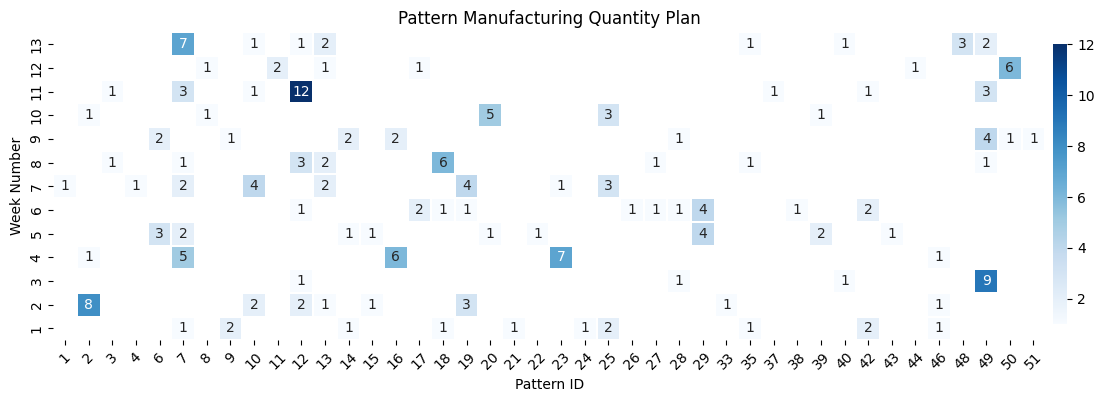

In [30]:
%pip install seaborn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import os, sys

records = [(key[0], key[1], value) for key, value in Pattern_used.items()]       # Sample records for demonstration
df = pd.DataFrame(records, columns=['x', 'y', 'value'])                          # Create a DataFrame
pivot_table = df.pivot(index='y', columns='x', values='value').fillna(0)         # Pivot the DataFrame to create a matrix format
masked_table = pivot_table.mask(pivot_table == 0)                                # Remove zeros by masking them

plt.figure(figsize=(16, 4))                                                      # Visualization using seaborn heatmap
heatmap = sns.heatmap(masked_table, annot=True, fmt=".0f", cmap='Blues',
                      #cbar_kws={'label': 'Pallets Used', 'orientation': 'vertical'},
                      cbar=True,
                      linewidths=0.01)  # Use mask to hide NaNs

plt.gcf().axes[-1].set_position([0.75, 0.15, 0.02, 0.7])  # Adjusting color bar position

# Remove x and y axis labels if needed
plt.title('Pattern Manufacturing Quantity Plan')
plt.xlabel('Pattern ID')
plt.ylabel('Week Number')
plt.xticks(rotation=45)     # Rotate x labels for better readability
plt.gca().invert_yaxis()    # Invert Y-axis
plt.show()

### 4.3. Weekly Storage Quantity

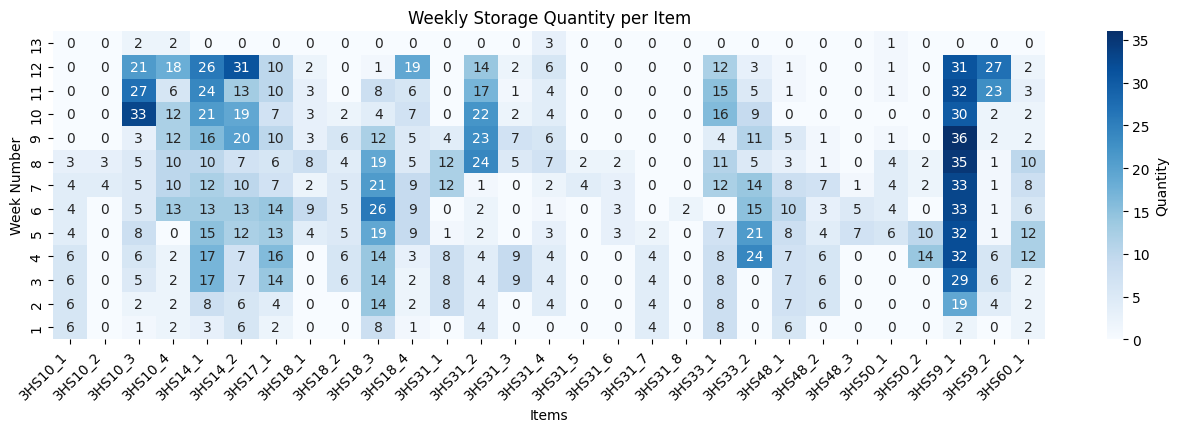

In [31]:

# Convert to DataFrame
records = [(key[0], key[1], value) for key, value in Storage.items()]
df = pd.DataFrame(records, columns=['Item', 'Week', 'Quantity'])

# Create a pivot table
pivot_table = df.pivot(index='Week', columns='Item', values='Quantity').fillna(0)

# Visualization using seaborn heatmap
plt.figure(figsize=(16, 4))            # Adjust the figure size as needed
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='Blues', cbar_kws={'label': 'Quantity'})
plt.title('Weekly Storage Quantity per Item')
plt.xlabel('Items')
plt.ylabel('Week Number')
plt.xticks(rotation=45, ha='right')    # Rotate x labels for better readability
plt.gca().invert_yaxis()               # Invert Y-axis
plt.show()

### 4.4. Bin Usage Distribution: Item Placement by Bin

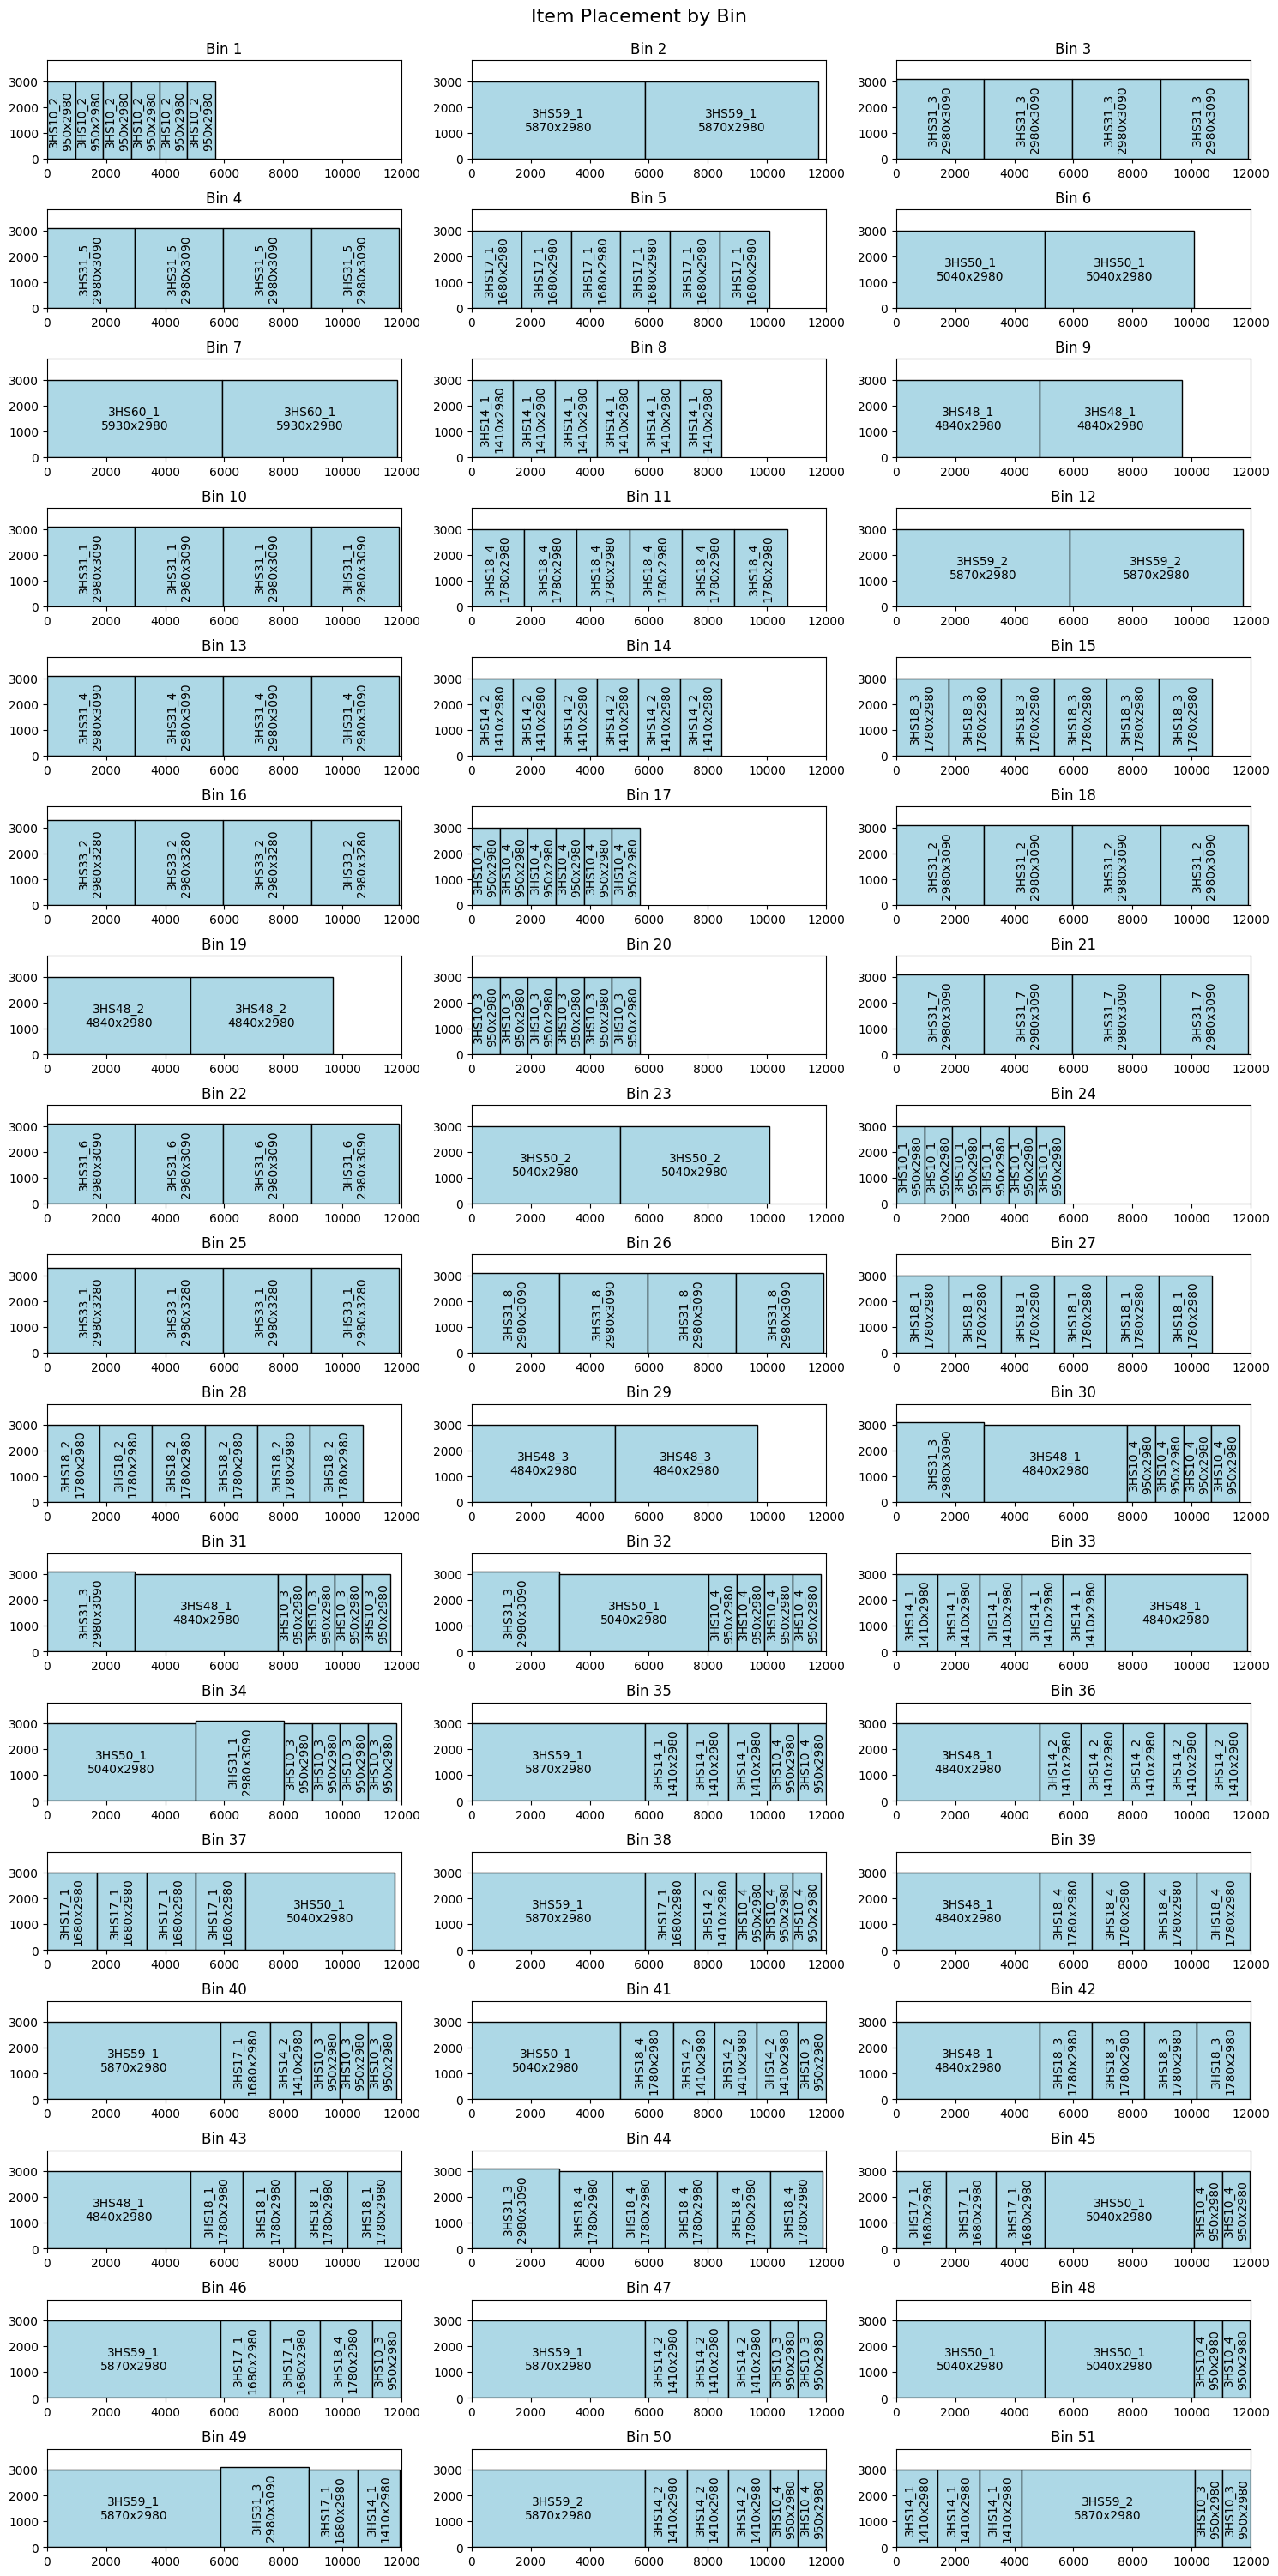

In [33]:
# Function to visualize the bin packing results, showing only N bins
def visualize_bins_grid_with_y_values(Pattern_used, prodAtr_dict, N):
    # Determine the unique bins from the amplvar_x keys
    bins = sorted(set(index for (_, index) in Pattern_items.keys()))  # Sort bins for consistent layout
    
    # Specify the bins to hide
    bins_to_hide = {''}  # Bins to hide
    bins_to_display = [bin_index for bin_index in bins if bin_index not in bins_to_hide]  # Filter out hidden bins
    
    # Limit to N bins
    bins_to_display = bins_to_display[:N]  # Adjust if you still want to limit by N
    num_bins_to_display = len(bins_to_display)

    # Calculate the number of rows and columns for the grid
    cols = 3  # Set the number of columns for the grid
    rows = math.ceil(num_bins_to_display / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(15, 1.8 * rows))
    axs = axs.flatten()  # Flatten the 2D array of axes for easy indexing

    for i, bin_index in enumerate(bins_to_display):
        ax = axs[i]  # Select the current subplot
        current_x = 0  # To place items sequentially along the X-axis
        
        # Iterate through amplvar_x and create rectangles for items in the current bin
        for (item, index), value in Pattern_items.items():
            if value > 0 and index == bin_index:  # Only plot items assigned to the current bin
                item_width = prodAtr_dict[(item, 'width')]
                item_height = prodAtr_dict[(item, 'height')]
                
                for _ in range(int(value)):  # Create multiple rectangles if value > 1
                    # Create the rectangle with width and height
                    rect = patches.Rectangle((current_x, 0), item_width, item_height, edgecolor='black', facecolor='lightblue')
                    ax.add_patch(rect)

                    # Prepare the text to be displayed
                    text_content = f'{item}\n{item_width}x{item_height}'

                    # Determine whether to rotate based on the rectangle's dimensions
                    rotation_angle = 0
                    if item_width < item_height:  # Rotate if the width is smaller than the height
                        rotation_angle = 90
                    
                    # Add the text to the rectangle with appropriate rotation
                    ax.text(current_x + item_width / 2, item_height / 2, 
                            text_content, ha='center', va='center', fontsize=10, color='black', 
                            rotation=rotation_angle, rotation_mode='anchor')

                    # Move the X position forward based on item width
                    current_x += item_width

        # Set plot limits and labels for the current bin
        ax.set_xlim(0, ampl.param['binDim']['width'])  # Adjust the width as needed
        ax.set_ylim(0, ampl.param['binDim']['height'])  # Set height limit for the bin
        ax.set_aspect('auto')

        # Set the title to the bin number from Pattern_items
        ax.set_title(f'Bin {bin_index}')  # Title for each bin plot

    # Hide any unused subplots
    for j in range(num_bins_to_display, len(axs)):
        axs[j].axis('off')  # Turn off any unused axes

    plt.tight_layout()  # Adjust subplots to fit into the figure area
    # Create a space for the title
    plt.suptitle('Item Placement by Bin', fontsize=16)
    plt.subplots_adjust(top=0.96)  # Adjusts the top of the subplots, leave space for the title

    plt.show()  # Show the complete figure with the specified bins

# Define bin dimensions (adjust as needed)
N = len(Pattern_items)  # Set the number of bins to display
visualize_bins_grid_with_y_values(Pattern_items, prodAtr_dict, N)


## 5. Extensions

Solve the problem taking into account that if the plant works then production should be exactly mode_atr[m, 'Pallet per week']


## 6. Appendix: Data approximation for constructing a model of the heating-cooling process of a steam chamber


In [ ]:
df = pd.read_csv('concrete_alpha.csv')          # Load the CSV data into a pandas DataFrame
alpha_dict = {}                                 # Initialize the dictionary for prodAtr

for index, row in df.iterrows():
    index_ = int(row['Temperature'])            # Convert to int to remove .0
    alpha_dict[index_] = float(row['alpha'])    # Store alpha value directly

data = {                                        # Original data dictionary
    10: 35,
    20: 50,
    30: 75,
    40: 112.5,
    50: 168.75,
    60: 233.13,
    70: 319.69,
    80: 439.53,
    90: 630.00}

# Create lists of temperatures and values from the dictionary
temperatures = np.array(list(data.keys()))
values = np.array(list(data.values()))

# Create an array of temperatures from 20 to 90
interp_temperatures = np.arange( min(np.array(list(data.keys()))), max(np.array(list(data.keys())))+1)

# Interpolate values for the new temperature range
interp_values = np.interp(interp_temperatures, temperatures, values)

# Create an interpolated dictionary with integer values
heatingCost = {int(temp): int(value) for temp, value in zip(interp_temperatures, interp_values)}